### Calibrating the CLASH noise kernel

In [1]:
import math as ma
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

from os.path import expanduser
from scipy.signal import fftconvolve
from skimage.util import view_as_blocks, view_as_windows
from multiprocessing import Pool, cpu_count

from wlenet import config
from wlenet.cluster.cluster_lensing import ClusterLensing
from wlenet.cluster.cluster_survey import ClusterSurvey
from wlenet.reduction.utils import load_image_and_wcs

In [2]:
noise_kernel_name = 'clash'
save_kernel = True
save_figures = True

In [3]:
%%capture
cluster_template = ClusterLensing(save_check_images=True, keep_image_wht=True, keep_image_bad_pix=True)
survey = ClusterSurvey(cluster_template)
survey.process_survey()

In [4]:
def cluster_noise_cov(cluster):
    
    image_wht = cluster.image_wht
    minus_objects_image = load_image_and_wcs(cluster.catalog_phot_orig['workdir'] +  '/minus_objects.fits')[0]
    segmentation_image = load_image_and_wcs(cluster.catalog_phot_orig['workdir'] +  '/segmentation.fits')[0]
    minus_background_image = load_image_and_wcs(cluster.catalog_phot_orig['workdir'] +  '/minus_background.fits')[0]

    K = np.ones(cluster_template.stamp_sz)
    K = K / np.sum(K)
    
    image_wht_smooth = fftconvolve(image_wht, K, 'same')    
    no_detection_image = segmentation_image == 0
    mask = (no_detection_image * (image_wht_smooth > cluster_template.cut_params['mean_wht_min']) * 
            (cluster.image_bad_pix == False)) == False
    noise_image = minus_background_image.copy()
    noise_image[mask] = np.nan

    patches = (view_as_windows(noise_image, (7, 7), step=4).reshape(-1, 7, 7)).copy()
    good_ind = np.sum(np.isnan(patches), axis=(1, 2)) == 0
    patches = patches[good_ind, :, :].reshape((-1, 49))
    cov = (patches.T).dot(patches) / patches.shape[0]
    
    return cov

In [5]:
%%capture
mp_pool_size = cpu_count() - 1
pool = Pool(mp_pool_size)
covs = pool.map(cluster_noise_cov, survey.clusters)
mean_cov = np.mean(np.array(covs), axis=0)

In [ ]:
for i, cov in enumerate(covs):
    plt.imshow(cov)
    print(i, survey.clusters[i].name)
    plt.show()
pass

In [7]:
sqrt_mean_cov = np.real(sp.linalg.sqrtm(mean_cov))
noise_kernel = sqrt_mean_cov[24, :].reshape((7, 7))

In [8]:
if save_kernel:
    noise_kernel_path = config['calibration_path'] + '/' + noise_kernel_name + '_noise_kernel.npy'
    np.save(expanduser(noise_kernel_path), noise_kernel)

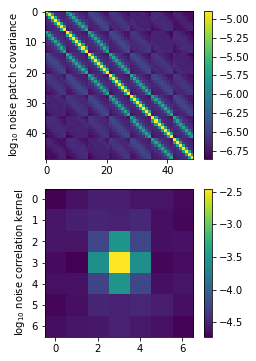

In [9]:
plt.figure(figsize = (4, 6))
plt.subplot(2,1,1)
plt.imshow(np.log10(mean_cov))
plt.colorbar()
plt.ylabel('$\log_{10}$ noise patch covariance')

plt.subplot(2,1,2)
plt.imshow(np.log10(noise_kernel))
plt.colorbar()
plt.ylabel('$\log_{10}$ noise correlation kernel');

if save_figures:
    fig_path = expanduser(config['figure_path'] + '/calibration/clash_noise_kernel.pdf')
    plt.savefig(fig_path)

The background subtracted noise image was computed and the noise covariance was estimated from all 5x5 pixel patches contained in regions unmasked by detected sources and having a mean weight image above 50,000. Computing a matrix square root of the covariance matrix, we obtain from its central row a kernel that generates these noise correlations by convolution with i.i.d. standard normal noise images.

In [10]:
survey.remove_tmp_files()